In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
import os
from pathlib import Path
import re


def extract_fields_from_okc(file_path, fields):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Read header to get number of fields and points
    header = lines[0].strip()
    n_fields, n_points, foo = map(int, header.split())
    # Read field names in the next n_fields lines
    field_names = [line.strip() for line in lines[1:(n_fields + 1)]]

    # Data starts at line 2 * n_fields + 1
    start_data_lines = (2 * n_fields + 1)

    df = pd.read_csv(file_path, sep=r'\s+', skiprows=start_data_lines, names=field_names)
    sliced_df = df[fields]
    return sliced_df

def cartesian_df_to_polar(dataframe):
    df = dataframe
    r = np.sqrt(df['x'].values ** 2 + df['y'].values ** 2)
    theta = np.arctan2(df['y'].values, df['x'].values)
    r_mean = np.mean(r)
    r_fluct = r - r_mean
    return theta, r, r_fluct

def interpolated_FFT(theta, signal):
    # Define uniform theta range
    theta_uniform = np.linspace(theta[0], theta[-1], 2 * len(theta), endpoint=False)

    # Interpolate r to uniform theta
    r_interp = interp1d(theta, signal, kind='cubic')
    r_uniform = r_interp(theta_uniform)

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(r_uniform)
    spect_wave_num = np.fft.fftfreq(len(r_uniform), d=(theta_uniform[1] - theta_uniform[0]))
    # Convert to one-sided over angular frequency
    pos_ind = len(spect_wave_num) // 2
    wave_num = 2 * np.pi * spect_wave_num[:pos_ind]

    # Get magnitudes
    amplitudes = np.abs(fft_coeffs)[:pos_ind] * 2
    return wave_num, amplitudes

def get_dominant_mode(theta, signal):
    signal_omegas, signal_amplitudes = interpolated_FFT(theta, signal)
    dominant_mode = int(signal_omegas[np.argmax(signal_amplitudes)])
    
    return dominant_mode
    

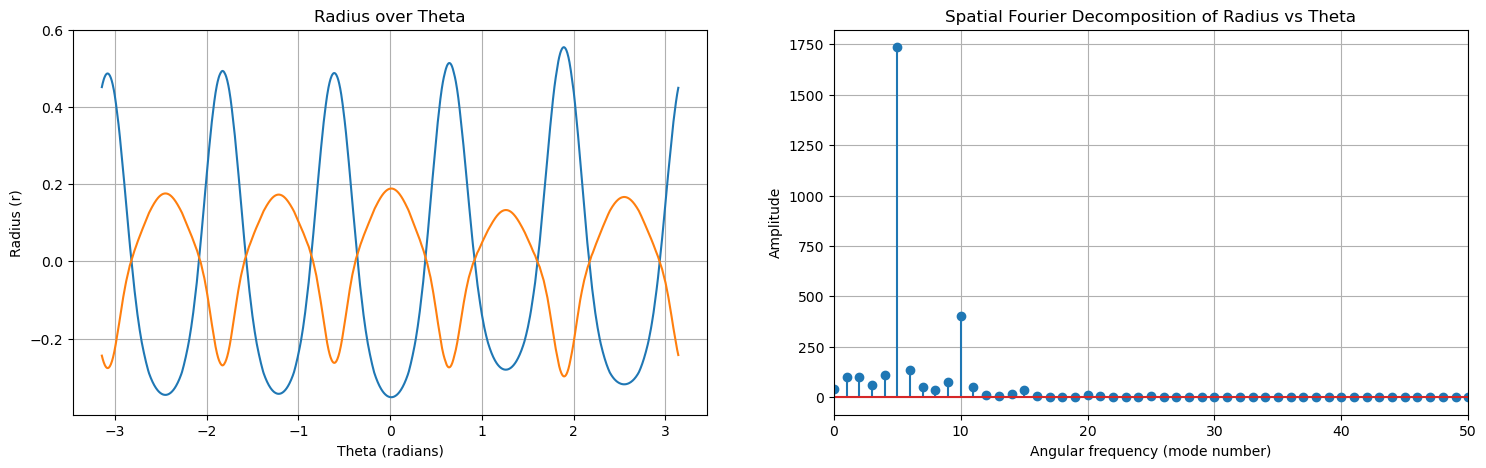

Shape seems to be 5-sided


In [ ]:
username = os.getlogin()
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6/Uin_01.50_RUN01/database/Isotherm_t_50.00.okc")
df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)
velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

# Get the indices that would sort theta
sorted_indices = np.argsort(theta_unsorted)

# Apply the sorting to the arrays
theta = theta_unsorted[sorted_indices]
r = r_unsorted[sorted_indices]
r_fluc = r_fluc_unsorted[sorted_indices]
velocity_mag = velocity_mag_unsorted[sorted_indices]
vel_mag_fluc = velocity_mag - np.mean(velocity_mag)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# Plot r vs. theta
axes[0].plot(theta, r_fluc)
axes[0].plot(theta, vel_mag_fluc)
axes[0].set_xlabel('Theta (radians)')
axes[0].set_ylabel('Radius (r)')
axes[0].set_title('Radius over Theta')
axes[0].grid(True)

r_fluc_omega, r_fluc_amp = interpolated_FFT(theta, r_fluc)

# Plot the spectrum
axes[1].stem(r_fluc_omega, r_fluc_amp)
axes[1].set_xlabel('Angular frequency (mode number)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Spatial Fourier Decomposition of Radius vs Theta')
axes[1].grid(True)
axes[1].set_xlim(0, 50)
plt.show()

dominant_mode = int(r_fluc_omega[np.argmax(r_fluc_amp)])
print(f"Shape seems to be {dominant_mode}-sided")

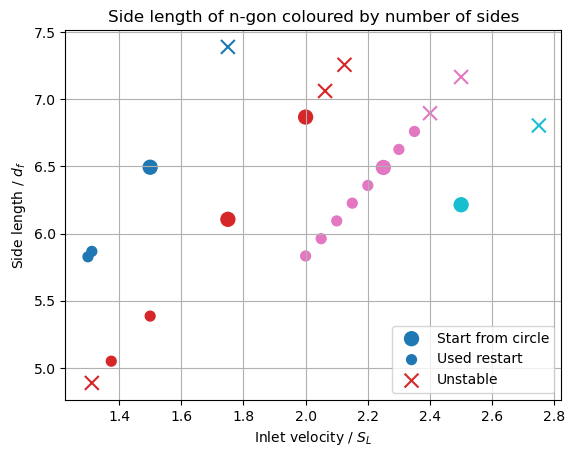

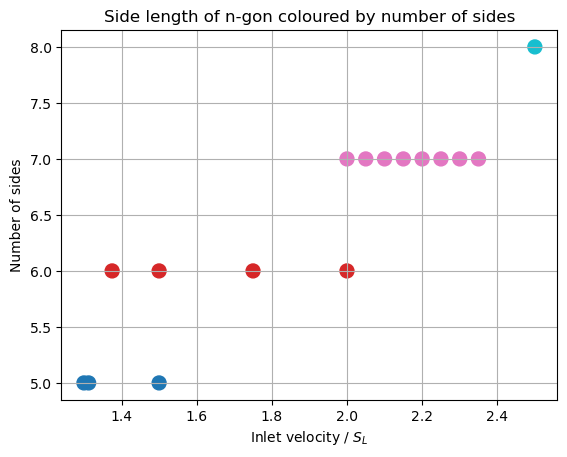

17.25103627841971 6.5684012280012425


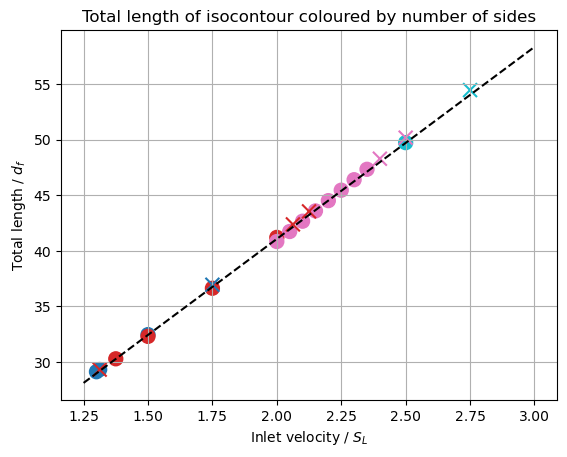

[6.75109387 6.00097233]


In [ ]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
runs = ["01.30_01", "01.3125_03", "01.375_02", "01.50_02", "01.50_03", "01.75_01", "02.00_02", "02.00_06","02.05_01", "02.10_01", 
        "02.15_01", "02.20_01", "02.25_02", "02.30_02", "02.35_01", "02.50_02"]
circle_starts = ["01.50_02", "01.75_01", "02.00_02", "02.25_02", "02.50_02"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1

length_sides = []
num_sides = []
inlet_vels = []
is_nr = []

for run in runs:
    if run in circle_starts:
        is_nr.append(True)
    else:
        is_nr.append(False)

    u_in, run_num = run.split("_")
    run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"

    # find the Isocontour file with the latest time
    db_files_dir = run_dir / "database"
    all_files = os.listdir(db_files_dir)

    # Filter files that match the pattern and extract time
    matches = []
    for f in all_files:
        match = re.match(r"Isotherm_t_(\d+)", f)
        if match:
            time_val = int(match.group(1))
            matches.append((f, time_val))

    # Find the file with the largest time
    if matches:
        final_Isocon = max(matches, key=lambda x: x[1])[0]
    else:
        print("[WARNING] No matching files found.")
    filepath = db_files_dir / final_Isocon
    df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
    theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)
    velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

    # Get the indices that would sort theta
    sorted_indices = np.argsort(theta_unsorted)
    theta = theta_unsorted[sorted_indices]
    r = r_unsorted[sorted_indices]
    r_fluc = r_fluc_unsorted[sorted_indices]
    
    _num_sides = get_dominant_mode(theta, r_fluc)
    num_sides.append(_num_sides)
    inlet_vels.append(float(u_in)) 
    #df = extract_fields_from_okc(run_dir, ['x', 'y', 'x_velocity', 'y_velocity'])
    filepath = run_dir / "timeseries_meanvel_len.csv"
    timeseries = pd.read_csv(filepath, sep=r'\s+')
    total_length = float(timeseries['total_length'].iloc[-1])
    length_sides.append(total_length / _num_sides)

length_sides = np.array(length_sides)
num_sides = np.array(num_sides)
inlet_vels =np.array(inlet_vels)
is_nr = np.array(is_nr)

df = pd.read_csv(f"unstable_cases.csv", skipinitialspace=True)
inlet_vels_us = df['u_in'].values
num_sides_us = df['num_side'].values
tot_length_us = df['l_tot'].values

# Define shared color range
vmin = num_sides.min()
vmax = num_sides.max()
plt.scatter(inlet_vels[is_nr], length_sides[is_nr], c=num_sides[is_nr], cmap='tab10', 
            vmin=vmin, vmax=vmax, s=100, marker='o', label='Start from circle')
plt.scatter(inlet_vels[~is_nr], length_sides[~is_nr], c=num_sides[~is_nr], cmap='tab10', 
            vmin=vmin, vmax=vmax, s=50, marker='o', label='Used restart')
plt.scatter(inlet_vels_us, tot_length_us/num_sides_us, c=num_sides_us, cmap='tab10', 
            vmin=vmin, vmax=vmax, s=100, marker='x', label='Unstable')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Side length / $d_f$")
plt.title("Side length of n-gon coloured by number of sides")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(inlet_vels, num_sides, c=num_sides, cmap='tab10', s=100, marker='o')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Number of sides")
plt.title("Side length of n-gon coloured by number of sides")
#plt.legend()
plt.grid(True)
plt.show()

plt.scatter(inlet_vels, num_sides * length_sides, c=num_sides, cmap='tab10', s=100, marker='o')
plt.scatter(inlet_vels_us, tot_length_us, c=num_sides_us, cmap='tab10', s=100, marker='x')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Total length / $d_f$")
plt.title("Total length of isocontour coloured by number of sides")
#plt.legend()
plt.grid(True)
l_slope, l_intercept, r_value, p_value, std_err = linregress(inlet_vels, num_sides * length_sides)
#x_fit = np.linspace(min(inlet_vels), max(inlet_vels), 100)
x_fit = np.linspace(1.25, 3.0, 100)
y_fit = l_slope * x_fit + l_intercept
y_pred = 3 * x_fit
plt.plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
print(l_slope, l_intercept)
#plt.plot(x_fit, y_pred, color='blue', label='Fit')
plt.show()

def predict_shape(u_in, slope, intercept):
    l_tot_pred = u_in * slope + intercept
    num_sides = []
    l_sides = []
    for num_side in range(4,10):
        l_side = l_tot_pred / num_side
        if l_side > 5.8 and l_side < 6.8:
            num_sides.append(num_side)
            l_sides.append(l_side)
    print(num_sides)
    print(l_sides)


In [ ]:
username = os.getlogin()
#case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
#case1 = "base_18.4k_phi_0.75"
case1 = "le1_18.4k_phi_0.75"
#runs = ["01.75_01", "01.75_02"]
#runs = ["01.75_01"]
#runs = ["02.00_01", "02.00_02"]
#runs = ["02.25_01", "02.25_02"]
#runs = ["02.50_01", "02.50_02"]
#runs = ["02.75_02"]
runs = ["02.75_01", "02.75_02"]
#runs = ["03.00_01"]
#runs = ["10.00_02", "10.00_03"]
#runs = ["01.75_03", "01.75_04", "01.75_05", "01.75_06"]

dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1

num_modes = 50
lengths_list = []
amp_time_series_list = []
k_time_series_r_list = []
time_list = []
for run in runs:   
    # Set directories of run
    u_in, run_num = run.split("_")
    run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"
    db_files_dir = run_dir / "database"

    # Extract the total contour lengths
    filepath = run_dir / "timeseries_meanvel_len.csv"
    timeseries = pd.read_csv(filepath, sep=r'\s+')
    total_lengths  = timeseries['total_length'].values

    # Find all files at different times and create empty arrays
    all_files = np.array(os.listdir(db_files_dir))
    k_time_series_r = np.empty((len(all_files), num_modes))
    amp_time_series_r = np.empty((len(all_files), num_modes))
    time = np.empty((len(all_files)))
    for i, file in enumerate(all_files):
        match = re.match(r"Isotherm_t_(\d+.\d+)", file)
        time_val = float(match.group(1))
        time[i] = time_val

    sorted_indices = np.argsort(time)
    time = time[sorted_indices]
    all_files = all_files[sorted_indices]
    for i, file in enumerate(all_files):
        # Read the file
        df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
        theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Sort arrays by theta
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r = r_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]
        
        # Perform spatial FFT on the real length data
        r_fluc_k_r, r_fluc_amp_r = interpolated_FFT(theta / (2*np.pi) * total_lengths[i], r_fluc)
        amp_time_series_r[i] = r_fluc_amp_r[1:num_modes+1]
        k_time_series_r[i,:] = r_fluc_k_r[1:num_modes+1]

    # Create list from all run arrays
    lengths_list.append(total_lengths)
    time_list.append(time)
    amp_time_series_list.append(amp_time_series_r)
    k_time_series_r_list.append(k_time_series_r)
# Concatenate arrays into one
lengths_tot = np.concatenate(lengths_list)
time_tot = np.concatenate(time_list)
amp_tot = np.concatenate(amp_time_series_list)
k_r_tot = np.concatenate(k_time_series_r_list)

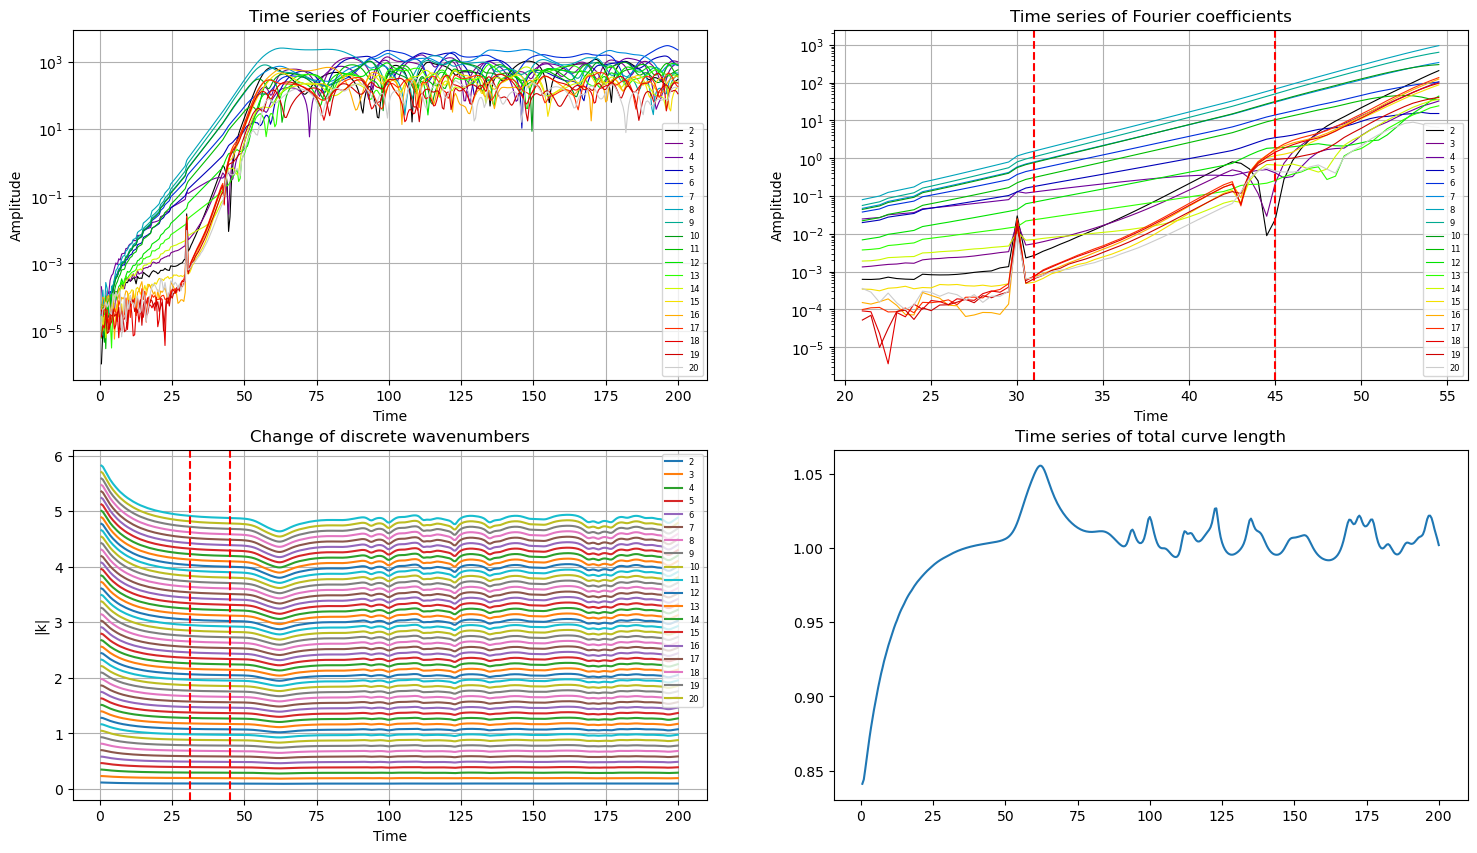

0.093	0.401	0.0078
0.201	0.502	0.0078
0.231	0.602	0.0078
0.255	0.703	0.0078
0.267	0.803	0.0078
0.270	0.903	0.0078
0.261	1.004	0.0078
0.244	1.104	0.0078
0.224	1.204	0.0078
0.166	1.305	0.0078
64.18940998304295


In [ ]:
# Extract dispersion relation
plt_s = slice(1, 20)
#modes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13] # Mode n-1
modes = list(range(3, 13))
t_start = 31
t_end = 45
t_start_ind = closest_index = np.argmin(np.abs(time_tot - t_start))
t_end_ind = closest_index = np.argmin(np.abs(time_tot - t_end))

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))

# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for i in range(plt_s.start, plt_s.stop):
    axes[0, 0].semilogy(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Time series of Fourier coefficients')
axes[0, 0].grid(True)
axes[0, 0].legend(prop={'size': 6})

# Plot narrowed range to show linear growth better
for i in range(plt_s.start, plt_s.stop):
    axes[0, 1].semilogy(time_tot[max(0, t_start_ind-20):t_end_ind+20], amp_tot[max(0, t_start_ind-20):t_end_ind+20,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 1].axvline(x=t_start, color='red', linestyle='--')
axes[0, 1].axvline(x=t_end, color='red', linestyle='--')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Time series of Fourier coefficients')
axes[0, 1].grid(True)
axes[0, 1].legend(prop={'size': 6})

# Plot change of wavenumber
axes[1, 0].plot(time_tot, k_r_tot)
axes[1, 0].axvline(x=t_start, color='red', linestyle='--')
axes[1, 0].axvline(x=t_end, color='red', linestyle='--')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('|k|')
axes[1, 0].set_title('Change of discrete wavenumbers')
axes[1, 0].grid(True)
axes[1, 0].legend([str(i+1) for i in range(plt_s.start, plt_s.stop)], prop={'size': 6})

# Plot total length (inverse prop. to |k|)
axes[1, 1].plot(time_tot, lengths_tot/np.mean(lengths_tot))
axes[1, 1].set_title('Time series of total curve length')
axes[1, 0].set_xlabel('Time')

plt.show()


# Extract growth rate omega
log_modes = np.log(amp_tot[:,modes])
for i in range(log_modes.shape[1]):
    slope, intercept, r_value, p_value, std_err = linregress(time_tot[t_start_ind:t_end_ind], log_modes[t_start_ind:t_end_ind, i])
    k_mean = np.mean(k_r_tot[t_start:t_end, modes[i]])
    k_rel_err = (k_r_tot[t_end_ind, modes[i]] - k_r_tot[t_start_ind, modes[i]]) / k_r_tot[t_start_ind, modes[i]]
    print(f"{slope:.3f}\t{k_mean:.3f}\t{abs(k_rel_err):.4f}")

print(np.mean(lengths_tot[t_start_ind:t_end_ind]))

In [6]:
a = np.array([1,2,3])
a = a[np.array([1,1,1])]
plot_slice= slice(1,5)
# for i in range(*plot_slice.indices(1)):
#     print(i)
print(plot_slice.indices(0))

(0, 0, 1)


In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Assuming your simulation cases are in a directory, e.g., './cases'
case_base_dir =  Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dirs = [d for d in os.listdir(case_base_dir) if os.path.isdir(os.path.join(case_base_dir, d))]

case_selector = widgets.Dropdown(
    options=case_dirs,
    description='Case:',
    disabled=False,
)

display(case_selector)
print(case_selector)


Dropdown(description='Case:', options=('base_18.4k_phi_0.6', 'base_18.4k_phi_0.75', 'Comparison Plots', 'Final…

Dropdown(description='Case:', options=('base_18.4k_phi_0.6', 'base_18.4k_phi_0.75', 'Comparison Plots', 'Final Isotherms', 'Heat release rates', 'highres_72.6k_phi_0.6', 'large_23.6k_phi_0.6', 'le1_18.4k_phi_0.75', 'temp_transfer_files', 'Videos Pseudocolor YOH', 'Xmgrace HRR graphs'), value='base_18.4k_phi_0.6')
C:\Users\Florian\OneDrive - ETH Zurich\Semester 10\Master Thesis\Sim results\base_18.4k_phi_0.6


In [63]:
selected_case = case_selector.value
selected_case_path = os.path.join(case_base_dir, selected_case)
print(selected_case_path)

C:\Users\Florian\OneDrive - ETH Zurich\Semester 10\Master Thesis\Sim results\base_18.4k_phi_0.75
